In [3]:
import cv2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 15]



Load data

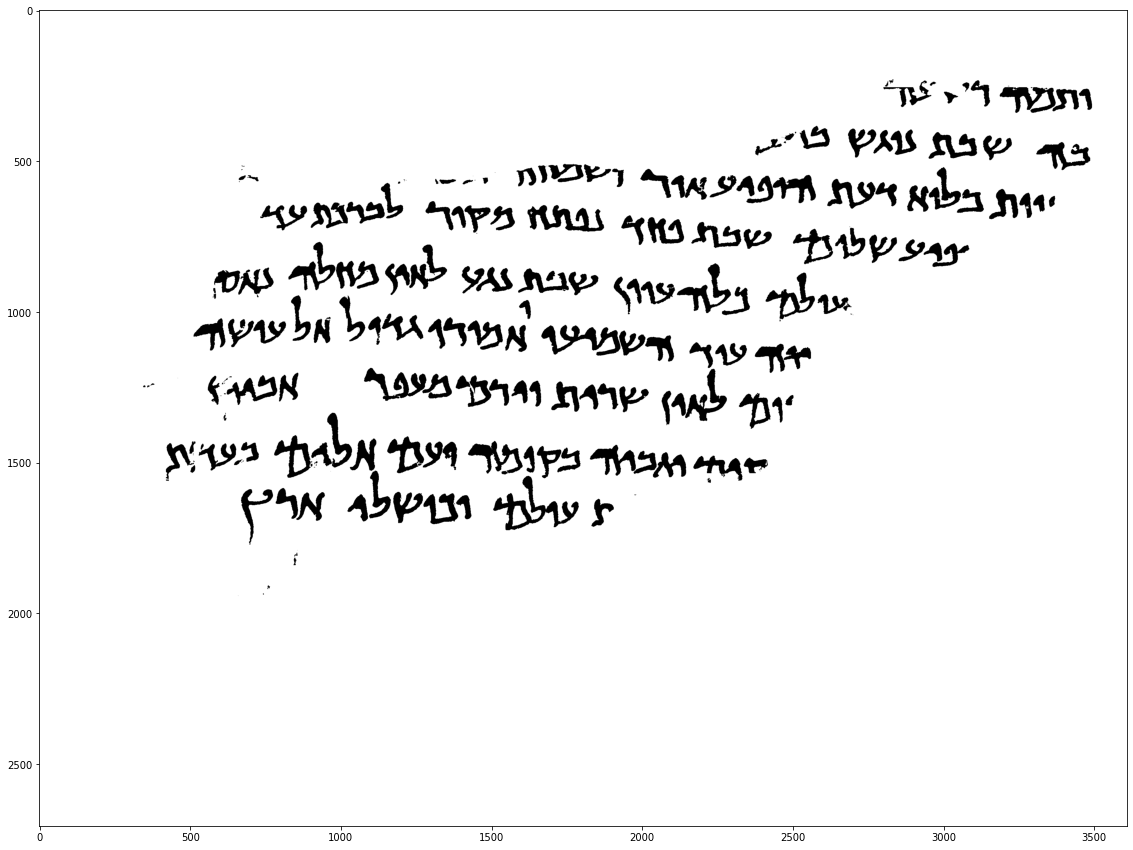

In [255]:
img = cv.imread('data/dss/scrolls/P513-Fg001-R-C01-R01-binarized.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
plt.imshow(img, 'binary')
img_c = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

def pimg(im, **kwargs):
    cim = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(im, **kwargs)
    plt.show()

# Get histograms, minima for line segmentation

In [182]:
y_sum = [sum(img[x,:]) for x in range(img.shape[0])]
x_sum = [sum(img[:,y]) for y in range(img.shape[1])]

#plt.plot(y_sum)

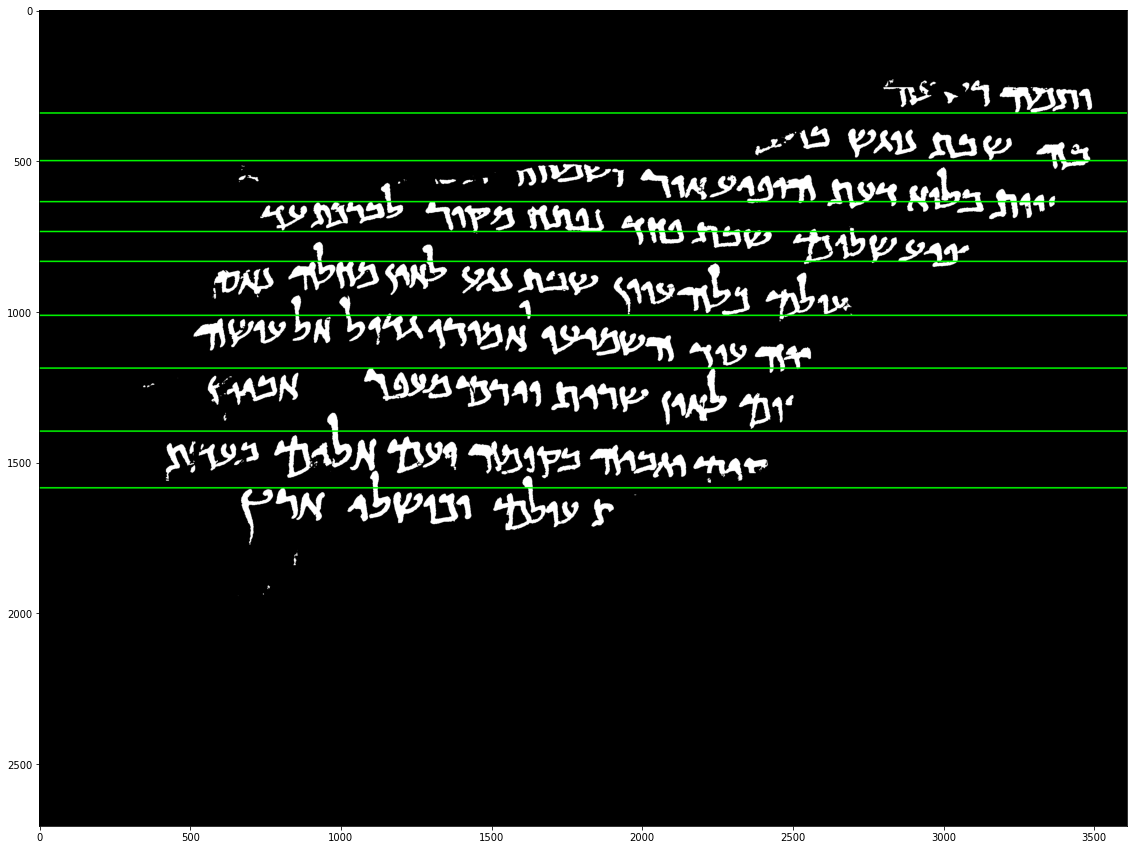

In [181]:
from peakdetect import peakdetect

maxima, minima = peakdetect(y_sum, lookahead=50)

img_min = cv.cvtColor(img.copy(), cv.COLOR_GRAY2RGB)
for msn in minima:
    mn = msn[0]
    cv.line(img_min, (0, mn), (10000, mn), (0, 255, 0), 4)

plt.imshow(img_min)

# Get connected components

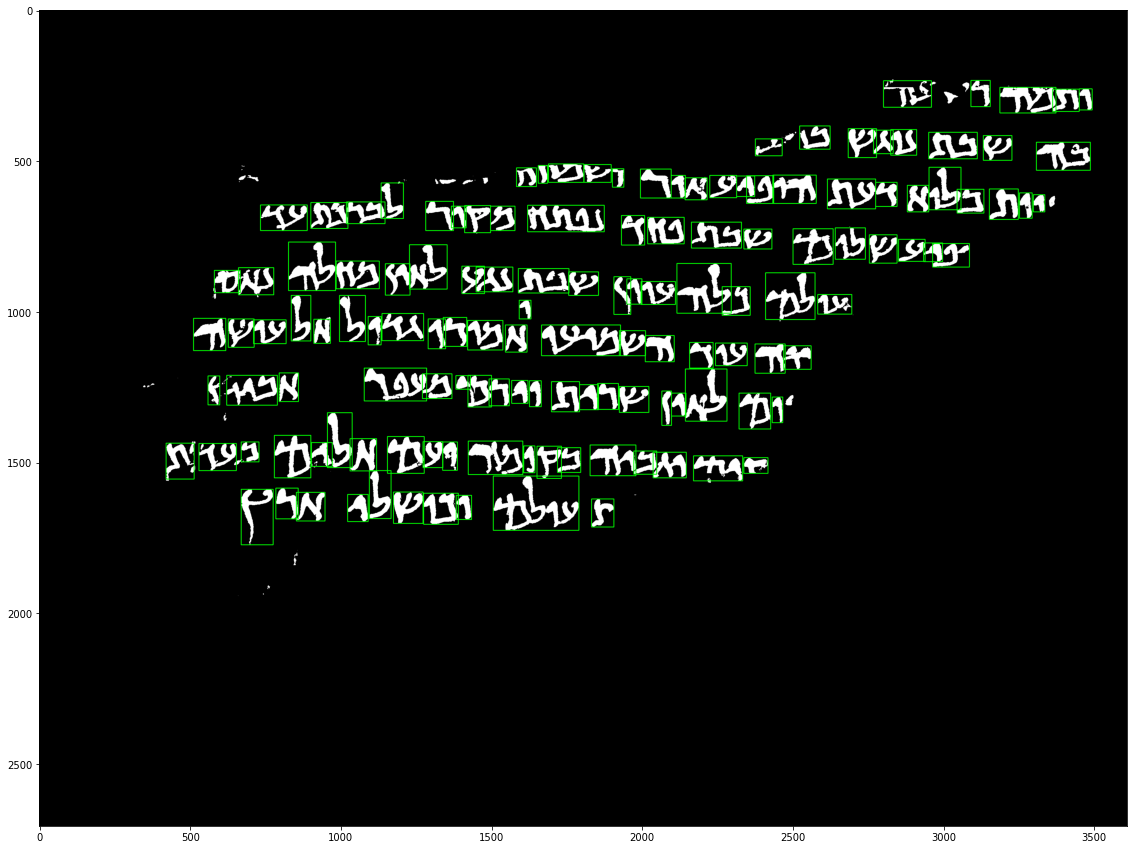

In [251]:
(_, _, stats, centroids) = cv.connectedComponentsWithStats(img)

sx = lambda stat: stat[0]
sy = lambda stat: stat[1]
sw = lambda stat: stat[2]
sh = lambda stat: stat[3]
sa = lambda stat: stat[4]

# One ccs is about the size of the image. removing that:
areas = np.array(list(map(sa, stats)))
# print(max(areas), img.shape[0] * img.shape[1])
idx = np.where(max(areas))
stats = np.delete(stats, idx, 0)
centroids = np.delete(centroids, idx, 0)
areas = np.delete(areas, idx, 0)

high_areas = np.where(areas>= 1000)
stats = stats[high_areas]
centroids = centroids[high_areas]

def print_ccs():
    imgc = cv.cvtColor(img.copy(), cv.COLOR_BGR2RGB)
    for stat in stats:
        x = sx(stat)
        y = sy(stat)
        w = sw(stat)
        h = sh(stat)
        cv.rectangle(imgc, (x,y), (x+w, y+h), (0,255,0), 2)
    plt.imshow(imgc)

print_ccs()

# Combine

TypeError: 'list' object cannot be interpreted as an integer

In [276]:
# ccs_per_line[i] contains all centroid indices for line i
ccs_per_line = []

for i in range(len(minima)+1):
    curr_y = img.shape[1] if i == len(minima) else minima[i][0]
    last_y = 0 if i==0 else minima[i-1][0]
    ccs_curr_line = []
    for j in range(len(centroids)):
        cx, cy = centroids[j]
        if last_y <= cy < curr_y:
            ccs_curr_line.append(j)
    ccs_per_line.append(ccs_curr_line)

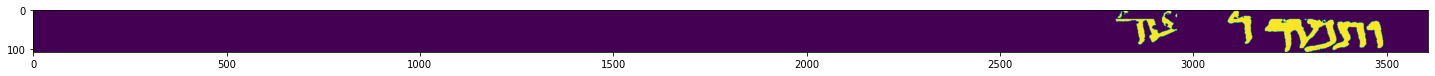

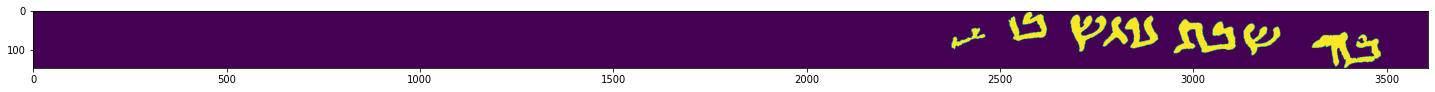

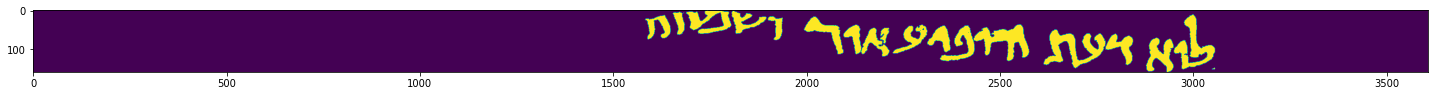

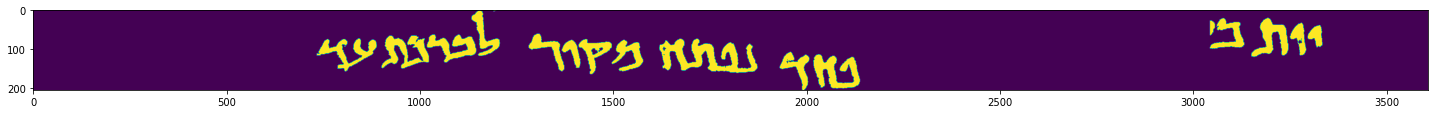

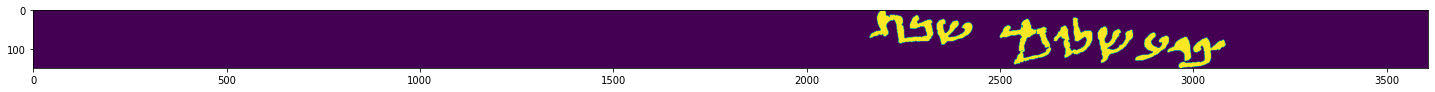

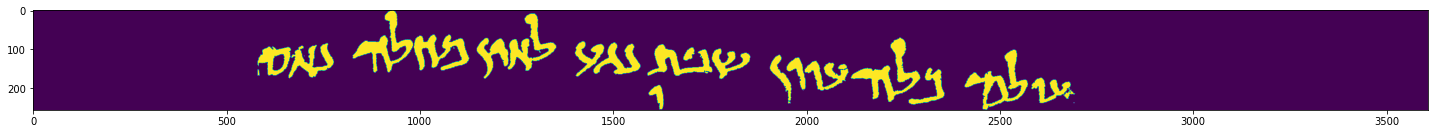

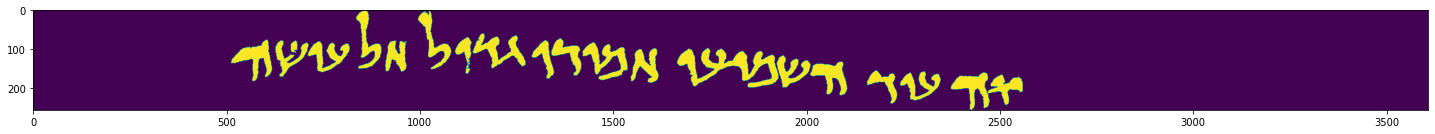

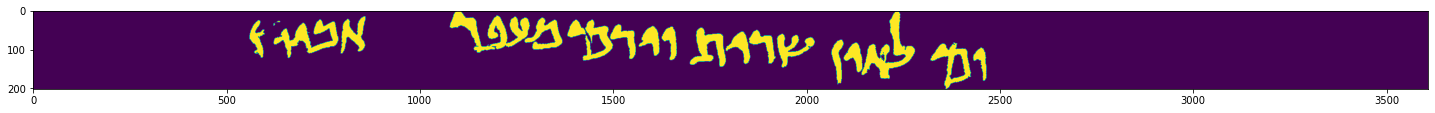

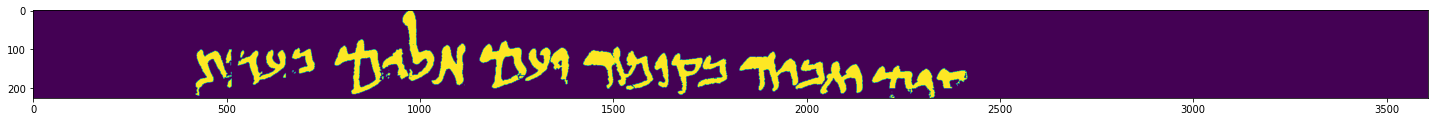

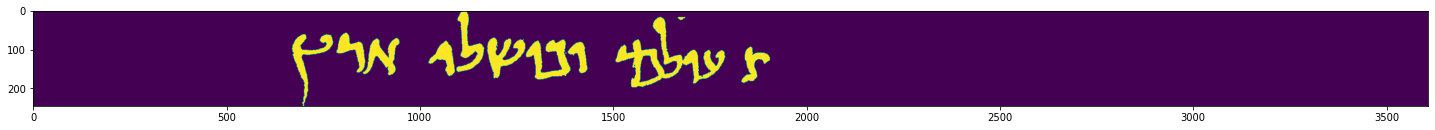

In [277]:
def get_line_img(line_idx, show_rect=False):
    curr_stats = stats[ccs_per_line[line_idx]]
    min_y = min(list(map(sy, curr_stats)))
    max_y = max(list(map(lambda s: sy(s) + sh(s), curr_stats)))
    arr = np.zeros((max_y-min_y, img.shape[1]), np.uint8)

    img_line = cv.cvtColor(arr, cv.COLOR_GRAY2RGB) if show_rect else arr
    # img_line = img_line[min_y:max_y, ...]

    for stat in curr_stats:
        x = sx(stat)
        y = sy(stat)
        w = sw(stat)
        h = sh(stat)
        y_local = y - min_y
        slice = img_c[y:y+h, x:x+w] if show_rect else img[y:y+h, x:x+w]
        img_line[y_local:y_local+h, x:x+w] = slice
        if show_rect:
            cv.rectangle(img_line, (x,y_local), (x+w, y_local+h), (0,255,0), 2)

    return img_line


line_imgs = [get_line_img(i) for i in range(len(ccs_per_line))]
for line_img in line_imgs: pimg(line_img)

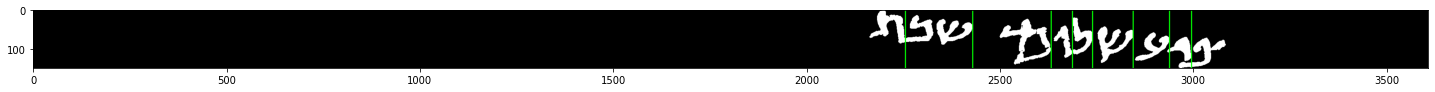

In [289]:
ci = line_imgs[4]
x_sum = [sum(ci[:,x]) for x in range(ci.shape[1])]

peaks, dals = peakdetect(x_sum, lookahead=40)
curr = ci.copy()
curr = cv.cvtColor(curr, cv.COLOR_GRAY2RGB)
for peak in dals:
    cv.line(curr, (peak[0], 0), (peak[0], curr.shape[0]), (0, 255, 0), 2)

plt.imshow(curr, 'binary')


# HOUGH (unused)

In [ ]:
centroids_small = centroids // 20
l = img.shape[0] // 20
w = img.shape[1] // 20
centroid_arr = np.zeros((l,w), np.uint8)
for centroid in centroids_small:
    x = int(centroid[1])
    y = int(centroid[0])
    centroid_arr[x,y] = 255
plt.imshow(centroid_arr)

def get_points_from_hough_cell(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    return (x1, y1), (x2, y2)

In [155]:
def euc_dist(a, b):
    (xa, ya) = a
    (xb, yb) = b
    return np.sqrt((xb-xa)**2 + (yb-ya)**2)

def lies_on_line(x, p, q):
    return euc_dist(p, x) + euc_dist(q, x) == euc_dist(p, q)

In [153]:
def get_ccs_from_hough_cell(rho, theta):
    res = []
    for rho_offset in range(-5, 6):
        print(f'offset={rho_offset}')
        p, q = get_points_from_hough_cell(rho+rho_offset, theta)
        print(f'points={p},{q}')
        for stat in stats:
            if lies_on_line((sx(stat), sy(stat)), p, q):
                res.append(stat)
    return res



In [154]:
lines = []
thresh = 0
while lines is not None:
    thresh += 1
    lines = cv.HoughLines(centroid_arr, R, np.pi/180, thresh)

lines = cv.HoughLines(centroid_arr, R, np.pi/180, thresh-1)

r0, t0 = lines[0][0]
ccs_stats = get_ccs_from_hough_cell(r0, t0)
print(ccs_stats)
ccs_heights = [sh(stat) for stat in ccs_stats]
#cv.line(centroid_img,(x1,y1),(x2,y2),(0,255,0),1)


offset=-5
points=(-999, -47),(996, 91)
offset=-4
points=(-999, -46),(995, 92)
offset=-3
points=(-999, -45),(995, 93)
offset=-2
points=(-999, -44),(995, 94)
offset=-1
points=(-999, -43),(995, 95)
offset=0
points=(-999, -42),(995, 96)
offset=1
points=(-999, -41),(995, 97)
offset=2
points=(-999, -40),(995, 98)
offset=3
points=(-999, -39),(995, 99)
offset=4
points=(-999, -38),(995, 100)
offset=5
points=(-999, -37),(995, 101)
[]


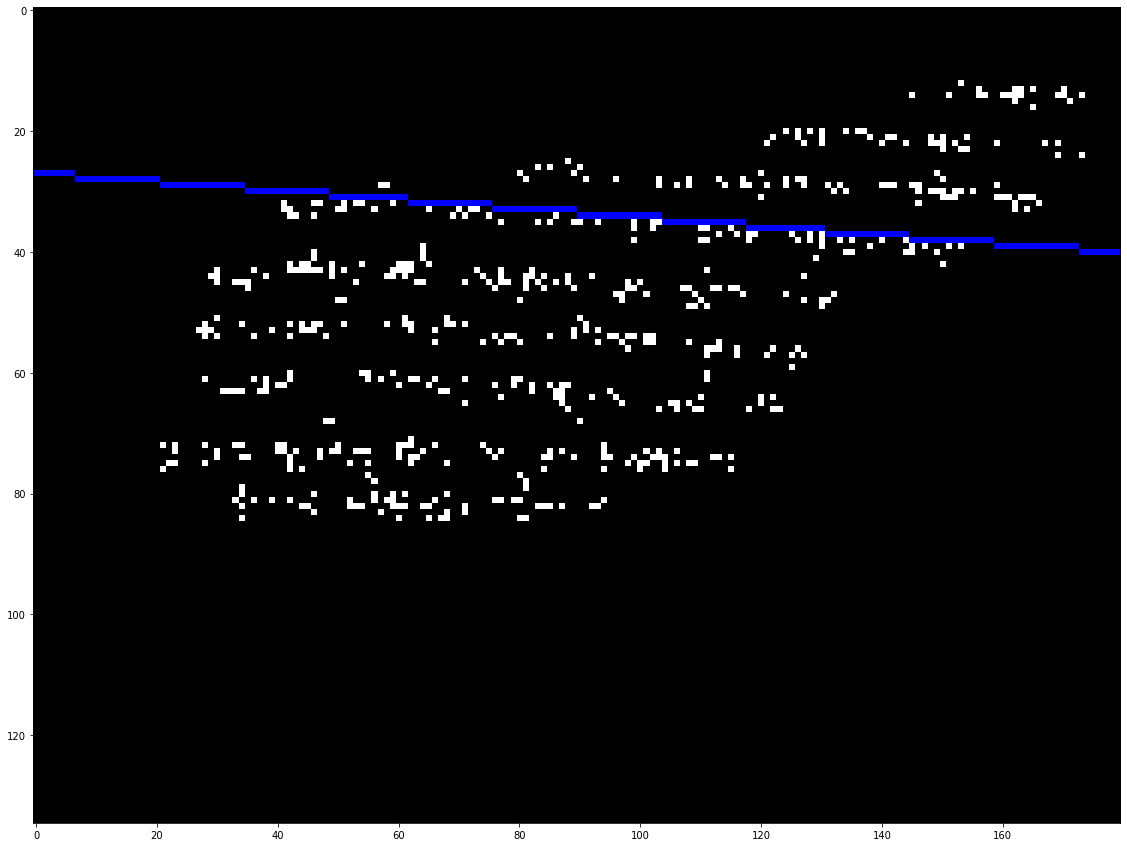

In [150]:
def line_img(arr, lines):
    centroid_img = cv.cvtColor(arr, cv.COLOR_GRAY2RGB)
    for [[rho,theta]] in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))

        y2 = int(y0 - 1000*(a))

        cv2.line(centroid_img,(x1,y1),(x2,y2),(0,0,255),1)
    plt.imshow(centroid_img)
line_img(centroid_arr, cv.HoughLines(centroid_arr, R, np.pi/180, 54))